In [1]:
"""IMPORTS"""
import numpy as np
from helpers import *
from implementations import *
from utils import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
"""LOADING RAW DATA"""
data_path = 'dataset'
x_tr_raw, x_te_raw, y_tr_raw, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

In [7]:
"""REMOVE USELESS COLUMNS"""
columns_to_remove = np.concatenate((range(1, 25), range(54, 56)))

x_tr_remove_col = np.delete(x_tr_raw, columns_to_remove, axis=1)
x_te_remove_col = np.delete(x_te_raw, columns_to_remove, axis=1)

"""TREATING SIMILARLY DON'T KNOW, REFUSE AND NAN"""
x_tr_dk = replace_dk_values_with_nan(x_tr_remove_col)
x_te_dk = replace_dk_values_with_nan(x_te_remove_col)

## HYPERPARAMETER SEARCH: DUP

0
Accuracy: 0.9089399180215461
F1-score: 0.3227561196736174
Accuracy: 0.91287122678166
F1-score: 0.33527086724017674
Accuracy: 0.9105855821536868
F1-score: 0.31751570132588974
Accuracy: 0.9100370274429732
F1-score: 0.313966999767604
Accuracy: 0.9112560379112256
F1-score: 0.3256137100509495
-----------------------------------------
1
Accuracy: 0.9104636811068615
F1-score: 0.3252181901699586
Accuracy: 0.9107989089856309
F1-score: 0.31866852886405955
Accuracy: 0.9097017995642037
F1-score: 0.3199449162267616
Accuracy: 0.9114236518506103
F1-score: 0.3260289855072464
Accuracy: 0.9110274734484283
F1-score: 0.32191383114620836
-----------------------------------------
2
Accuracy: 0.8948451094823777
F1-score: 0.40452152903615496
Accuracy: 0.8964145854602527
F1-score: 0.408355091383812
Accuracy: 0.8957746049644202
F1-score: 0.4015748031496063
Accuracy: 0.8941289408322795
F1-score: 0.3905263157894737
Accuracy: 0.8971307541103509
F1-score: 0.40765113626392907
--------------------------------------

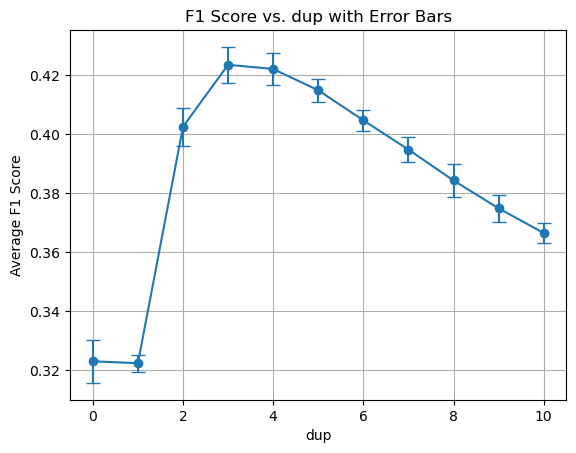

In [12]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed

# Define a list of values for dup to loop through
dup_values = range(0, 11)  # Goes from 0 to 10

# Initialize a list to store average F1 scores for each dup value
average_f1_scores = []
std_dev_f1_scores = []  # List to store standard deviation of F1 scores


for dup in dup_values:
    print(dup)
    
    np.random.seed(1)
    # Create a KFold cross-validation splitter
    kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

    # Initialize a list to store F1 scores for this dup value
    f1_scores = []

    for i in range(k):
        # Get the indices for the current fold
        val_index = kf[i]
        train_index = np.concatenate([kf[j] for j in range(k) if j != i])

        # Split the data into training and validation sets for this fold
        x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
        y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

        # Nan to mean
        x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

        # Remove columns with one unique value
        x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

        # Standardize
        x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

        # Duplicate
        x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, dup)
        tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

        # Perform least squares regression for this fold
        w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

        # Evaluate the model on the validation set for this fold
        f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

        # Append the MSE score for this fold to the list
        f1_scores.append(f1)

    # Calculate the average F1 score over all folds for this dup value
    # Calculate the average F1 score and standard deviation over all folds for this dup value
    average_f1 = np.mean(f1_scores)
    std_dev_f1 = np.std(f1_scores)
    average_f1_scores.append(average_f1)
    std_dev_f1_scores.append(std_dev_f1)
    print("-----------------------------------------")

# Create an error plot with error bars
plt.figure()
plt.errorbar(dup_values, average_f1_scores, yerr=std_dev_f1_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('dup')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. dup with Error Bars')
plt.grid(True)
plt.show()

In [ ]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed

# Define a list of values for dup to loop through
dup_values = range(0, 11)  # Goes from 0 to 10

# Initialize a list to store average F1 scores for each dup value
average_f1_scores = []
std_dev_f1_scores = []  # List to store standard deviation of F1 scores


for dup in dup_values:
    print(dup)
    # Create a KFold cross-validation splitter
    kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

    # Initialize a list to store F1 scores for this dup value
    f1_scores = []

    for i in range(k):
        # Get the indices for the current fold
        val_index = kf[i]
        train_index = np.concatenate([kf[j] for j in range(k) if j != i])

        # Split the data into training and validation sets for this fold
        x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
        y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

        # Nan to mean
        x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

        # Remove columns with one unique value
        x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

        # Standardize
        x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

        # Duplicate
        x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, dup)
        tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

        # Perform least squares regression for this fold
        w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

        # Evaluate the model on the validation set for this fold
        f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

        # Append the MSE score for this fold to the list
        f1_scores.append(f1)

    # Calculate the average F1 score over all folds for this dup value
    # Calculate the average F1 score and standard deviation over all folds for this dup value
    average_f1 = np.mean(f1_scores)
    std_dev_f1 = np.std(f1_scores)
    average_f1_scores.append(average_f1)
    std_dev_f1_scores.append(std_dev_f1)
    print("-----------------------------------------")

# Create an error plot with error bars
plt.figure()
plt.errorbar(dup_values, average_f1_scores, yerr=std_dev_f1_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('dup')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. dup with Error Bars')
plt.grid(True)
plt.show()

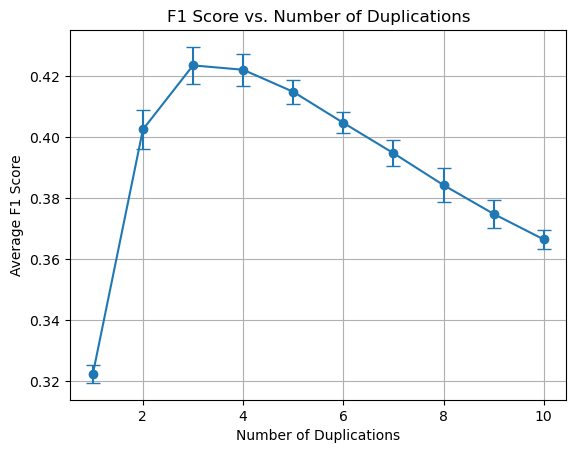

In [18]:
dup_values2 = dup_values[1:]
average_f1_scores2 = average_f1_scores[1:]
std_dev_f1_scores2 = std_dev_f1_scores[1:]

# Create an error plot with error bars for the modified data
plt.figure()
plt.errorbar(dup_values2, average_f1_scores2, yerr=std_dev_f1_scores2, marker='o', linestyle='-', capsize=5)
plt.xlabel('Number of Duplications')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. Number of Duplications')
plt.grid(True)
plt.show()

## HYPERPARAMETER SEARCH: LAMBDA

In [8]:
"""SPLITTING TRAINING DATA INTO TRAINING AND VALIDATION"""
x_tr_sp, x_val_sp, y_tr_sp, y_val_sp = split_data(x_tr_dk, y_tr_raw, ratio=0.8, seed=1)

In [9]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed

# Define a list of values for dup to loop through
lambdas = [0, 0.0001, 0.0005, 0.001, 0.005] # Goes from 0 to 10
dup = 3

# Initialize a list to store average F1 scores for each dup value
average_f1_scores = []
std_dev_f1_scores = []  # List to store standard deviation of F1 scores


for lambda_ in lambdas:
    print(lambda_)
    
    np.random.seed(10)
    # Create a KFold cross-validation splitter
    kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

    # Initialize a list to store F1 scores for this dup value
    f1_scores = []

    for i in range(k):
        # Get the indices for the current fold
        val_index = kf[i]
        train_index = np.concatenate([kf[j] for j in range(k) if j != i])

        # Split the data into training and validation sets for this fold
        x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
        y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

        # Nan to mean
        x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

        # Remove columns with one unique value
        x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

        # Standardize
        x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

        # Duplicate
        x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, dup)
        tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

        # Perform least squares regression for this fold
        w_LS, mse_LS = ridge_regression(y_tr_duplicated, tx_tr, lambda_)

        # Evaluate the model on the validation set for this fold
        f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

        # Append the MSE score for this fold to the list
        f1_scores.append(f1)

    # Calculate the average F1 score over all folds for this dup value
    # Calculate the average F1 score and standard deviation over all folds for this dup value
    average_f1 = np.mean(f1_scores)
    std_dev_f1 = np.std(f1_scores)
    average_f1_scores.append(average_f1)
    std_dev_f1_scores.append(std_dev_f1)
    print("-----------------------------------------")

# Create an error plot with error bars
plt.figure()
plt.errorbar(lambdas, average_f1_scores, yerr=std_dev_f1_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('lambda')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. lambda with Error Bars')
plt.grid(True)
plt.show()

0
Accuracy: 0.8747771496487726
F1-score: 0.41741103076704944


KeyboardInterrupt: 

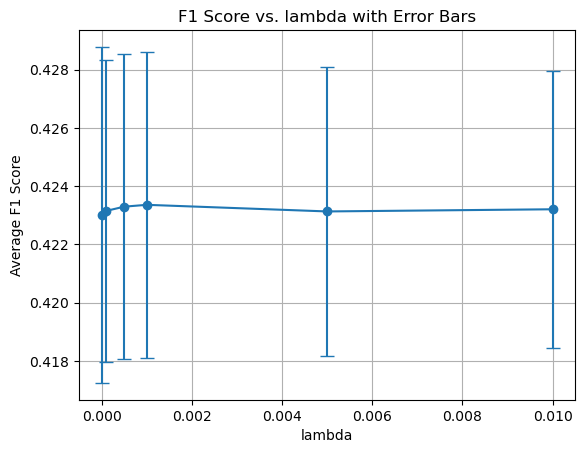

In [9]:
# Create an error plot with error bars
plt.figure()
plt.errorbar(lambdas, average_f1_scores, yerr=std_dev_f1_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('lambda')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. lambda with Error Bars')
plt.grid(True)
plt.show()

## VARYING LAMBDA AND DEGREE

In [6]:
"""SPLITTING TRAINING DATA INTO TRAINING AND VALIDATION"""
x_tr_sp, x_val_sp, y_tr_sp, y_val_sp = split_data(x_tr_dk, y_tr_sp, ratio=0.8, seed=1)

NameError: name 'x_tr_dk' is not defined

In [3]:
## Hyperparameter search
threshs = [1]
dups = [3]
lambdas = [0.00001, 0.000005, 0.0001, 0.0005, 0.001, 0.005, 0.01,  0.05]
degrees = []

f1_best = 0
dup_best = 100
thresh_best = 100
deg_best = 100
lambda_best = 100

top_10_results = []

x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_sp, x_val_sp)
x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)
x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

for deg in degrees:
    x_poly_tr = build_poly(x_tr_std, deg)
    x_poly_val = build_poly(x_val_std, deg)

    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 0)

    tx = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]
    
    for lambda_ in lambdas:
        print("Degree:", deg, "Lambda:", lambda_)
        
        w_rr = ridge_regression(y_val_sp, tx, lambda_)
        f1 = predict_and_evaluate(x_poly_val, w_rr, y_val_sp, regression_type = "mse")

        result = {
        "Degree": deg,
        "Lambda": lambda_,
        "F1 Score": f1
        }

        if f1 > f1_best:
            f1_best = f1
            deg_best = deg
            lambda_best = lambda_

        top_10_results.append(result)

print("BEST RESULT: ", "lambda: ", lambda_best, "degree: ", deg_best, "f1: ", f1_best)

top_10_results.sort(key=lambda x: x["F1 Score"], reverse=True)

print("Top 10 Results with the Highest F1 Scores:")
for i, result in enumerate(top_10_results[:10]):
    print(f"Rank {i + 1}:")
    print(f"Degree: {result['Degree']}")
    print(f"Lambda: {result['Lambda']}")
    print(f"F1 Score: {result['F1 Score']}")
    print("---------------------------------------------")

NameError: name 'x_tr_sp' is not defined

## BOX PLOT WITH DIFFERENT STEPS

### Raw

In [5]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_raw)), k)

# Initialize lists to store results from each fold
f1_step1 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_raw[train_index], x_tr_raw[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 0)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    f1_step1.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step1)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.8633794017706127
F1-score: 0.27377288190507043
Accuracy: 0.9122769591783869
F1-score: 0.2655951014159969
Accuracy: 0.9114693647431698
F1-score: 0.2702838482793268
Accuracy: 0.9106465326770994
F1-score: 0.25978288311032566
Accuracy: 0.9108903347707499
F1-score: 0.2623612512613522
Average F1 score over 5-fold cross-validation: 0.2663591931944144


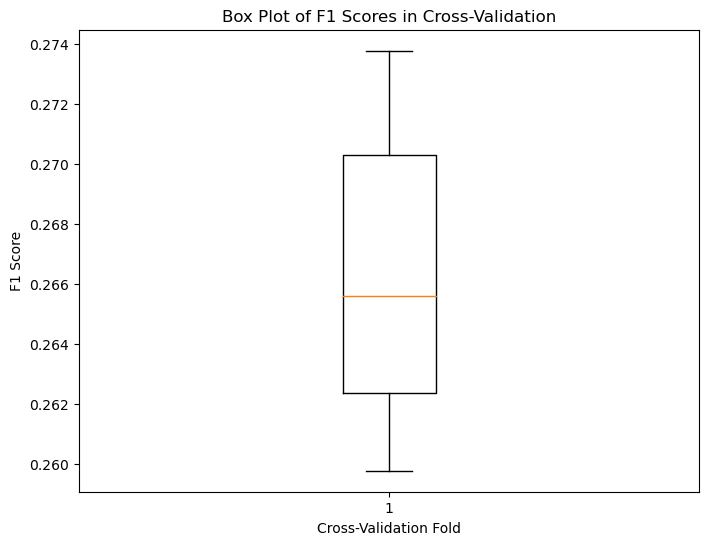

In [6]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(f1_step1)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

### dk values

In [7]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

# Initialize lists to store results from each fold
f1_step2 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 0)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    f1_step2.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step2)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.9087570664513082
F1-score: 0.30934256055363324
Accuracy: 0.9121702957624148
F1-score: 0.3274212368728121
Accuracy: 0.9108598595090436
F1-score: 0.3291284403669725
Accuracy: 0.9095189479939659
F1-score: 0.3141603141603142
Accuracy: 0.9114846023740228
F1-score: 0.32898232644103037
Average F1 score over 5-fold cross-validation: 0.32180697567895244


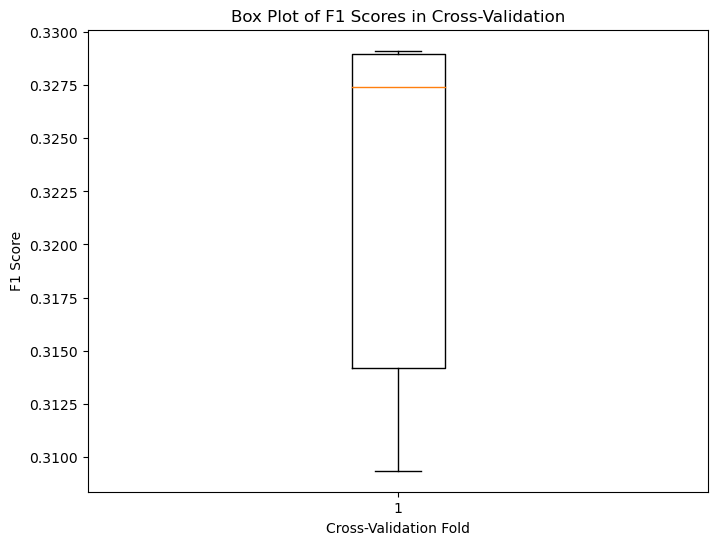

In [8]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(f1_step2)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

### Dup = 3

In [9]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

# Initialize lists to store results from each fold
f1_step3 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 3)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    f1_step3.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step3)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.8747771496487726
F1-score: 0.41741103076704944
Accuracy: 0.877672299510872
F1-score: 0.42302716688227693
Accuracy: 0.8774589726789279
F1-score: 0.42851051733939743
Accuracy: 0.8772913587395432
F1-score: 0.42482679808585105
Accuracy: 0.8765142395660322
F1-score: 0.42654967449759407
Average F1 score over 5-fold cross-validation: 0.42406503751443375


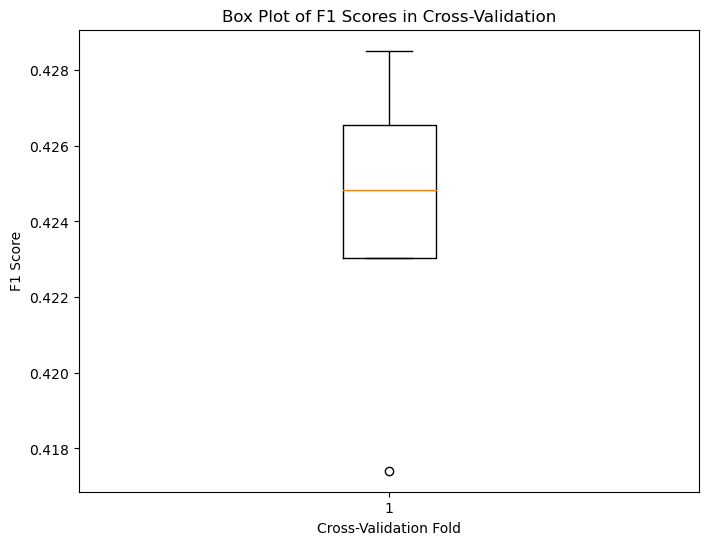

In [10]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(f1_step3)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

### Lambda

In [33]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed
lambda_ = 6e-5

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

# Initialize lists to store results from each fold
f1_step4 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 3)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = ridge_regression(y_tr_duplicated, tx_tr, lambda_)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    f1_step4.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step4)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.8747466743870663
F1-score: 0.41751700680272114
Accuracy: 0.8778856263428162
F1-score: 0.42370199913706313
Accuracy: 0.8776570618800189
F1-score: 0.42923153479775367
Accuracy: 0.8774284974172216
F1-score: 0.4246065808297568
Accuracy: 0.8764228137809134
F1-score: 0.4266119909502262
Average F1 score over 5-fold cross-validation: 0.42433382250350415


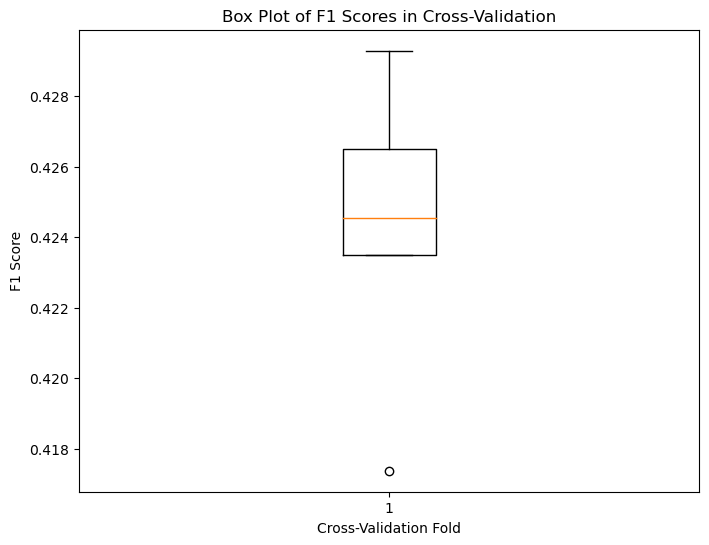

In [30]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(f1_step4)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

### Poly

In [13]:
# Define the number of folds (k) for cross-validation
k = 5  # You can choose the number of folds as needed
dup = 3
lambda_ = 0.00028
degree = 5

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

# Initialize lists to store results from each fold
f1_step5 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 3)
    x_poly_tr = build_poly(x_tr_duplicated, degree)
    x_poly_val = build_poly(x_val_std, degree)

    tx_tr = np.c_[np.ones((x_poly_tr.shape[0], 1)), x_poly_tr]

    # Perform least squares regression for this fold
    w_LS, mse_LS = ridge_regression(y_tr_duplicated, tx_tr, lambda_)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_poly_val, w_LS, y_val_fold)
    
    # Append the MSE score for this fold to the list
    f1_step5.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step5)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.8788760723482713
F1-score: 0.4340334638661445
Accuracy: 0.8816645587943986
F1-score: 0.4392779783393502
Accuracy: 0.8812379051305103
F1-score: 0.43871525277257667
Accuracy: 0.8809331525134472
F1-score: 0.4369505692462891
Accuracy: 0.8802169838633489
F1-score: 0.43773692868893505
Average F1 score over 5-fold cross-validation: 0.4373428385826591


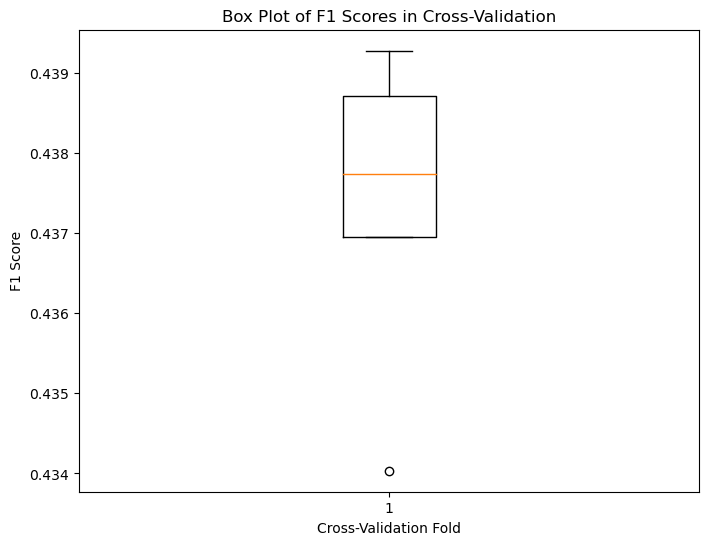

In [14]:
import matplotlib.pyplot as plt

# Assuming you have the `mse_scores` list from the previous code
# If not, make sure to compute it using cross-validation

# Create a box plot of the MSE scores
plt.figure(figsize=(8, 6))
plt.boxplot(f1_step5)
plt.title('Box Plot of F1 Scores in Cross-Validation')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('F1 Score')
plt.show()

### Box plots

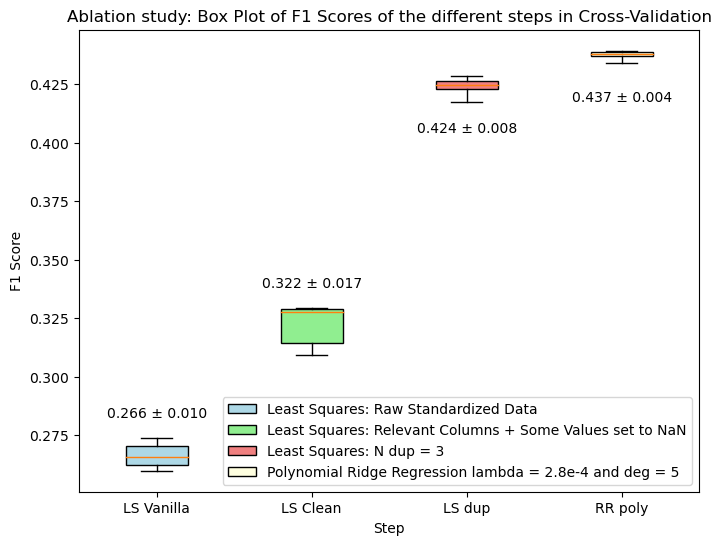

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the `f1_step1`, `f1_step2`, `f1_step3`, and `f1_step5` lists from your data
# If not, make sure to have these lists with your F1 scores

# Create a box plot of the F1 scores
plt.figure(figsize=(8, 6))  # Increased the figure width

# Create boxplots for each step
box1 = plt.boxplot(f1_step1, positions=[1], notch=False, patch_artist=True, widths=0.4, whis=2)  # Set whis to 2
box2 = plt.boxplot(f1_step2, positions=[2], notch=False, patch_artist=True, widths=0.4, whis=2)
box3 = plt.boxplot(f1_step3, positions=[3], notch=False, patch_artist=True, widths=0.4, whis=2)
box5 = plt.boxplot(f1_step5, positions=[4], notch=False, patch_artist=True, widths=0.4, whis=2)

# Set colors for the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for box, color in zip([box1, box2, box3, box5], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.title('Ablation study: Box Plot of F1 Scores of the different steps in Cross-Validation')
plt.xlabel('Step')
plt.ylabel('F1 Score')

# Calculate and add the mean values to the box plots
mean_values = [np.mean(f1_step1), np.mean(f1_step2), np.mean(f1_step3), np.mean(f1_step5)]
std_values = [np.std(f1_step1), np.std(f1_step2), np.std(f1_step3), np.std(f1_step5)]

for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    if i < 2:
        plt.text(i + 1, mean + 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=10)
    else:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='top', fontsize=10)

# Create a custom legend
legend_boxes = [box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box5["boxes"][0]]
plt.legend(legend_boxes, ['Least Squares: Raw Standardized Data', 'Least Squares: Relevant Columns + Some Values set to NaN', 'Least Squares: N dup = 3', 'Polynomial Ridge Regression lambda = 2.8e-4 and deg = 5'], loc='lower right')

# Set the x-axis ticks and labels
plt.xticks([1, 2, 3, 4], ['LS Vanilla', 'LS Clean', 'LS dup', 'RR poly'])

plt.show()
